In [1]:
from nuscenes.nuscenes import NuScenes
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import numpy as np
import os
from datetime import datetime
from celluloid import Camera
from pyquaternion import Quaternion
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes.utils.geometry_utils import view_points

mpl.rc('figure', max_open_warning = 0)
%matplotlib inline

nusc = NuScenes(version='v1.0-mini', dataroot='./data/nusc', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.6 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [2]:
one_instance = nusc.instance[599]
ann_tokens = nusc.field2token('sample_annotation', 'instance_token', one_instance['token'])
print("There are", len(ann_tokens), "annotations for instance 599")

There are 16 annotations for instance 599


In [3]:
def get_lidar_pointcloud(sample_token):
    sample_record = nusc.get('sample', sample_token)
    pointsensor_channel = 'LIDAR_TOP'
    pointsensor_token = sample_record['data'][pointsensor_channel]
    pointsensor = nusc.get('sample_data', pointsensor_token)
    pcl_path = nusc.get('sample_data', pointsensor_token)['filename']
    pc =LidarPointCloud.from_file(os.path.join('./data/nusc',pcl_path))
    return pointsensor_token, pc.points
def rotate_pointcloud(cloud, quaternion):
    def rot(an_array):
        return quaternion.rotate(an_array)
    return np.array(list(map(rot, cloud)))
def visualize_absolute(ax, absolute_points, ego_pose, van_translation, relativeboxvectors):
    #plt.axis('equal')
    axes = plt.gca()
    #axes.set_xlim([xmin,xmax])
    #axes.set_ylim([ymin,ymax])
    #ax.set(xlim=(300, 500), ylim=(1100, 1300))
    return ax.scatter(absolute_points[0], absolute_points[1], c='red', s=0.3), ax.scatter(ego_pose['translation'][0], ego_pose['translation'][1]),ax.plot([van_translation[0] + relativeboxvector[0] for relativeboxvector in relativeboxvectors], [van_translation[1] + relativeboxvector[1] for relativeboxvector in relativeboxvectors])[0]
def create_bounding_box(annotation_token):
    '''
    creates bounding box used for plotting
    '''
    van_annotation = nusc.get('sample_annotation', annotation_token)
    relativeboxvectors = [(van_annotation['size'][1]/2,van_annotation['size'][0]/2, 0),
                         (-van_annotation['size'][1]/2,van_annotation['size'][0]/2, 0),
                         (-van_annotation['size'][1]/2,-van_annotation['size'][0]/2, 0),
                         (van_annotation['size'][1]/2,-van_annotation['size'][0]/2, 0),
                         (van_annotation['size'][1]/2,van_annotation['size'][0]/2, 0)]
    return np.array(relativeboxvectors), van_annotation['translation']

(1805.2407454992765, 1906.5819606017021, 2479.463134147423, 2560.597899491819)

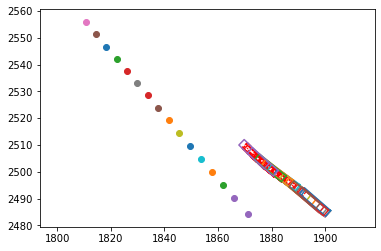

In [4]:
ims = []
fig = plt.figure()
ax = fig.add_subplot(111)  # fig and axes created once
frontimages = []
points2D = []
time_ls = []

# Display points and bounding box in global coordinates over whole scene
for i,current_van_annotation_token in enumerate(ann_tokens):

    # filter out points outside bounding box


    ## Grab the data

    van_annotation = nusc.get('sample_annotation', current_van_annotation_token)

    #get respective frame token
    sample_token = van_annotation['sample_token']
    sample = nusc.get('sample', sample_token)
    time_ls.append(sample['timestamp'])

    pointsensor_token, points = get_lidar_pointcloud(sample_token)
    calibrated_sensor_token = nusc.get('sample_data', pointsensor_token)['calibrated_sensor_token']
    calibrated_sensor = nusc.get('calibrated_sensor', calibrated_sensor_token)
    ego_pose = nusc.get('ego_pose', nusc.get('sample_data', pointsensor_token)['ego_pose_token'])

    ## translate points to global reference frame

    ### Rotate points around sensor and ego rotation

    pointsensor_quaternion = Quaternion(calibrated_sensor['rotation'])
    ego_quaternion = Quaternion(ego_pose['rotation'])

    sensor_rotated_points = np.dot(pointsensor_quaternion.rotation_matrix, points[:3,:])
    rotated_points = np.dot(ego_quaternion.rotation_matrix, sensor_rotated_points)

    # use broadcasting to add translation to x and y dimension
    absolute_points = rotated_points+np.array(ego_pose['translation'][:3]).reshape(-1,1)


    ### rotate points by inverse bounding box rotation (translation to its reference frame unnecessary for only filtering)
    reverse_van_quaternion = Quaternion(w=-1*van_annotation['rotation'][0], x=van_annotation['rotation'][1], y=van_annotation['rotation'][2], z=van_annotation['rotation'][3])
    points_bounding_rotation = np.dot(reverse_van_quaternion.rotation_matrix, absolute_points)

    #new stuff
    relativeboxvectors, position = create_bounding_box(current_van_annotation_token)

    rotated_box = relativeboxvectors+reverse_van_quaternion.rotate(position)

    x_max = rotated_box[:,0].max()
    x_min = rotated_box[:,0].min()

    y_max = rotated_box[:,1].max()
    y_min = rotated_box[:,1].min()

    ## Remove points that are outside the bounding box
    mask = np.ones(points_bounding_rotation.shape[1], dtype=bool)

    mask = np.logical_and(mask, points_bounding_rotation[0] > x_min)
    mask = np.logical_and(mask, points_bounding_rotation[0] < x_max)

    mask = np.logical_and(mask, points_bounding_rotation[1] > y_min)
    mask = np.logical_and(mask, points_bounding_rotation[1] < y_max)

    points_filtered_rotated = points_bounding_rotation[:,mask]

    ### rotate points back

    van_quaternion = Quaternion(van_annotation['rotation'])
    points_filtered_absolute = np.dot(van_quaternion.rotation_matrix, points_filtered_rotated)
    points2D.append(points_filtered_absolute[0:2, :])
    # append list of plots to movie
    rotated_relativeboxvectors = rotate_pointcloud(relativeboxvectors, van_quaternion)
    plotlist = visualize_absolute(ax, points_filtered_absolute, ego_pose, van_annotation['translation'], rotated_relativeboxvectors)

    ims.append(plotlist)     

ax.axis('equal')

In [5]:
ani = mpl.animation.ArtistAnimation(fig, ims, repeat=False)
ani.save('test.gif', writer='pillow')

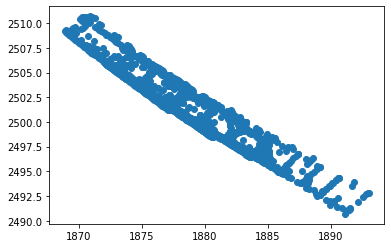

In [6]:
X = np.array([])
Y = np.array([])
for i in range(len(points2D)):
    X = np.append(X, points2D[i][0])
    Y = np.append(Y, points2D[i][1])
plt.scatter(X, Y)

In [7]:
mean_arr = np.array([]).reshape(0, 2)
for i in range(len(points2D)):
    temp = np.mean(points2D[i], axis=1).reshape(1,2)
    mean_arr = np.append(mean_arr, temp, axis=0)

D:\Code-related\Python\Python38\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Code-related\Python\Python38\lib\site-packages\numpy\core\_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


[1884.27085443 1885.19575301 1890.80182167 1890.09187689 1873.24898495
 1896.55370152 1892.5071282  1890.3910089  1885.10908017 1880.47486429
 1894.95209486 1877.7651341  1877.40925035           nan           nan
 1894.41512816]
[1884.27085443 1886.59150123 1891.87893512 1889.91025372 1873.8150851
 1891.38722808 1892.35824721 1890.67587172 1885.22316117 1881.6839439
 1891.4435358  1880.40355776 1878.08394008           nan 1876.83294745
 1888.43252956]


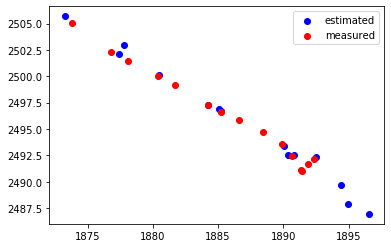

In [26]:
def kalman_filter(sigma, C_00, R):
    C_kk = C_00
    X_data = np.array(mean_arr[0][0])
    y_data = np.array(mean_arr[0][1])
    for k in range(len(points2D)-1):
        datatime1 = datetime.fromtimestamp(int(time_ls[k])/1e6)
        datatime2 = datetime.fromtimestamp(int(time_ls[k+1])/1e6)
        t = (datatime2 - datatime1).microseconds/1e6
        F = np.identity(4)
        F[0, 2] = t
        F[1, 3] = t

        velocity = (mean_arr[k+1] - mean_arr[k]) / t
        x_kk = np.array([mean_arr[k+1][0], mean_arr[k+1][1], velocity[0], velocity[1]]).reshape(4, 1)
        x_k1k = F.dot(x_kk)

        term = np.array([0.5*t*t, 0.5*t*t, t, t]).reshape(4, 1)
        Q = term.dot(sigma).dot(term.T)
        C_k1k = F.dot(C_kk).dot(F.T) + Q

        H = np.zeros((2, 4))
        H[0, 0] = 1
        H[1, 1] = 1
        y_k1 = mean_arr[k].reshape(2,1)

        S = H.dot(C_k1k).dot(H.T) + R
        K = C_k1k.dot(H.T).dot(np.linalg.inv(S))
        x_k1k1 = x_k1k + K.dot(y_k1 - H.dot(x_k1k))
        # update C_kk
        C_kk = C_k1k - K.dot(S).dot(K.T)
        X_data = np.append(X_data, x_k1k1[0][0])
        y_data = np.append(y_data, x_k1k1[1][0])
    return X_data, y_data


# sigma = np.array([1]).reshape(1, 1)
# np.random.seed(1)
# x=np.random.normal(size=4)
# y=np.random.normal(size=4)
# C_00 = np.cov(np.vstack((x, y)).T)
# x=np.random.normal(size=2)
# y=np.random.normal(size=2)
# R = np.cov(np.vstack((x, y)).T)

C_00 = 1*np.eye(4)
sigma = 0.1
r = 0.5
R = np.array(((r,0),(0,r)))


X_pred, y_pred = kalman_filter(sigma, C_00, R)

print(X_pred)
print(mean_arr[:, 0])
ax = plt.gca()
ax.scatter(X_pred, y_pred, color="b", label='estimated')
ax.scatter(mean_arr[:, 0], mean_arr[:, 1], color="r", label='measured')
plt.legend()